# Pendulum 환경에서 SRASA와 Q-Learning을 통해 최적의 policy 찾기

Pendulum openai gym: https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py

agent는 진자운동이 가능한 막대로 주어진다. Agent의 목적은 막대를 위로 세우고, 밸런스를 유지해야 하는 것이다. CartPole Env과 같이 state는 연속적인 값으로 주어지며, pendulum에서는 action 또한 continuous value로 주어야 한다.    

Observation matrix는 아래와 같다.

|Num|Observation|Min|Max|
|---|---|---|---|
|0|cos(theta)|-1.0|1.0|
|1|sin(theta)|-1.0|1.0|
|2|theta dot|-8.0|8.0|

Action은 Joint effort를 -2에서 2까지의 값으로 줄 수 있다. (swing left, swing right)

## Library Import

In [1]:
import gym
import numpy as np
import random
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt

## Env 살펴보기

In [2]:
env = gym.make('Pendulum-v1')
state = env.reset()
    
for j in range(200):
    time.sleep(1/50)
    env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    print(state, action, reward)
    
env.close()

[-0.9999096   0.01344864 -0.5887314 ] [1.2765923] -9.830054854484493
[-0.9993168   0.03695822 -0.47035185] [0.7219538] -9.820464122415501
[-0.9980914   0.06175365 -0.49652666] [-0.35928985] -9.660954881669403
[-0.99521667  0.09769244 -0.72111076] [-1.8059958] -9.513081589731705
[-0.9903358   0.13869008 -0.8258017 ] [-1.1864014] -9.3177860460192
[-0.9821498   0.18810055 -1.0017843 ] [-1.866668] -9.08640968239969
[-0.97443676  0.22466199 -0.7473668 ] [0.75561416] -8.817386321503172
[-0.9668774   0.25524122 -0.6300206 ] [-0.34100237] -8.553176637707763
[-0.9637853   0.26667947 -0.23697793] [1.3440785] -8.356045314420912
[-0.9667786  0.2556152  0.2292418] [1.7747343] -8.255119619343281
[-0.97283345  0.23150605  0.49716946] [0.50810856] -8.317828960619579
[-0.98051715  0.19643341  0.71812755] [0.31552354] -8.481090217302786
[-0.9863758   0.16450767  0.6492053 ] [-1.4416485] -8.720040380998563
[-0.9924061   0.12300472  0.83883667] [0.44167066] -8.900904651806258
[-0.9968696   0.07906316  0.8

[-0.5675507  -0.82333845  0.35460898] [-0.43453988] -4.911310653747896
[-0.57752836 -0.8163706  -0.24339764] [0.1299815] -4.740277719251632
[-0.60643977 -0.7951294  -0.7175508 ] [0.920832] -4.78752889029291
[-0.6607317 -0.7506222 -1.4043543] [-0.60304296] -4.990787559739312
[-0.72267205 -0.6911911  -1.7173463 ] [1.6664973] -5.455964558125612
[-0.80419827 -0.5943611  -2.5332985 ] [-1.9837254] -5.9559194604339165
[-0.87832   -0.4780732 -2.7602265] [1.4589527] -6.919523191075673
[-0.9400302  -0.34109116 -3.007645  ] [0.74091005] -7.74858589439565
[-0.9832598  -0.18220907 -3.2968953 ] [-0.22287993] -8.70836970840774
[-0.999825   -0.01870772 -3.2904773 ] [0.953832] -9.839755361464665
[-0.9896724   0.14334764 -3.2510395 ] [0.3564563] -10.835254566107814
[-0.9533143  0.3019798 -3.2585118] [-0.7665526] -10.044015411335621
[-0.89075184  0.45448998 -3.3006163 ] [-1.7905966] -9.101222654749126
[-0.8204175  0.5717649 -2.7371175] [1.4842094] -8.219404821346272
[-0.7538858  0.6570055 -2.1636858] [0.

## Discretize state and action

**State 뿐만 아니라 Action 또한 continuous data로 구성되어 있다. SARSA와 Q-Learning을 사용하여 학습하기 위해서 이들을 discrete value로 변환해 주어야 한다.**

In [3]:
print('State bound: ', env.observation_space.low, env.observation_space.high)
print('Action bound: ', env.action_space.low, env.action_space.high)

State bound:  [-1. -1. -8.] [1. 1. 8.]
Action bound:  [-2.] [2.]


theta는 \[-3.14, 3.14\]의 범위를 갖는다. env에서 주어지는 state에서 sin, cos에 대한 역삼각함수를 통해 theta값을 구해서 사용하자.  
(env.state를 통해서도 theta값을 바로 얻을 수 있음)

In [4]:
state_bins = [50, 50]

theta_space = np.linspace(-3.14, 3.14, state_bins[0])
theta_dot_space = np.linspace(-8, 8, state_bins[1])

state_list = [theta_space, theta_dot_space]
state_list

[array([-3.14      , -3.01183673, -2.88367347, -2.7555102 , -2.62734694,
        -2.49918367, -2.37102041, -2.24285714, -2.11469388, -1.98653061,
        -1.85836735, -1.73020408, -1.60204082, -1.47387755, -1.34571429,
        -1.21755102, -1.08938776, -0.96122449, -0.83306122, -0.70489796,
        -0.57673469, -0.44857143, -0.32040816, -0.1922449 , -0.06408163,
         0.06408163,  0.1922449 ,  0.32040816,  0.44857143,  0.57673469,
         0.70489796,  0.83306122,  0.96122449,  1.08938776,  1.21755102,
         1.34571429,  1.47387755,  1.60204082,  1.73020408,  1.85836735,
         1.98653061,  2.11469388,  2.24285714,  2.37102041,  2.49918367,
         2.62734694,  2.7555102 ,  2.88367347,  3.01183673,  3.14      ]),
 array([-8.        , -7.67346939, -7.34693878, -7.02040816, -6.69387755,
        -6.36734694, -6.04081633, -5.71428571, -5.3877551 , -5.06122449,
        -4.73469388, -4.40816327, -4.08163265, -3.75510204, -3.42857143,
        -3.10204082, -2.7755102 , -2.44897959, -2

In [5]:
action_bins = 20

action_space = np.linspace(-1.99, 2, action_bins)
action_space

array([-1.99, -1.78, -1.57, -1.36, -1.15, -0.94, -0.73, -0.52, -0.31,
       -0.1 ,  0.11,  0.32,  0.53,  0.74,  0.95,  1.16,  1.37,  1.58,
        1.79,  2.  ])

In [6]:
def discretize_state(state):
    th = np.arccos(state[0])
    th = int(min(state_bins[0] - 1, np.digitize(th, state_list[0])))
    thdot = int(min(state_bins[1] - 1, np.digitize(state[2], state_list[0])))
    return th, thdot

def discretize_action(action):
    bins = 20
    action_space = np.linspace(-1.99, 2, bins)
    
    action += -1e-6
    idx = int(min(bins - 1, np.digitize(action, action_space)))
    ret = action_space[idx]
    return ret, idx

In [7]:
temp_action = env.action_space.sample()
print(temp_action, discretize_action(temp_action))

[1.6786429] (1.7900000000000003, 18)


## Redner function


In [8]:
def test(Q):
    state = env.reset()
    done = False
    env.render()
    for i in range(200):
        ds = discretize_state(state)
        action_idx = np.argmax(Q[ds])
        action = action_space[action_idx] - 1e-6
        state, reward, done, info = env.step([action])
        env.render()
    env.close()

## SARSA

In [51]:
env = gym.make('Pendulum-v1')

Q_SARSA = np.zeros([state_bins[0], state_bins[1], action_bins])
alpha = 0.1
gamma = 0.99
epsilon = 0.2

all_reward = []
epi_reward = 0

for i in range(1, 500001):
    state = env.reset()
    ds = discretize_state(state)
    
    if random.uniform(0, 1) < epsilon:
        action = env.action_space.sample()
        action, action_idx = discretize_action(action)
    else:
        action_idx = np.argmax(Q[ds]) 
        action = action_space[action_idx] -1e-6
    
    tr = 0
    done = False
    
    while not done:
        tr += 1
        
        if tr > 200:
            break
        
        next_state, reward, done, info = env.step([action])
        nds = discretize_state(next_state)
        
        if random.uniform(0, 1) < epsilon:
            next_action = env.action_space.sample()
            next_action, next_action_idx = discretize_action(next_action)
        else:
            next_action_idx = np.argmax(Q[nds])
            next_action = action_space[next_action_idx] -1e-6
        
        Q_SARSA[ds][action_idx] = (1 - alpha) * Q_SARSA[ds][action_idx] + alpha * (reward + gamma * Q_SARSA[nds][next_action_idx])
        
        action = next_action
        action_idx = next_action_idx
        ds = nds
        
        epi_reward += reward
        
        if done:
            break
    
    if i % 100 == 0:
        print('Episode:', i)
    
    if i % 1000 == 0:
        clear_output(wait=True)
        all_reward.append(epi_reward)
        print('Episode:', i)
        print('Average reward', epi_reward / 1000)
        epi_reward = 0

print('학습 완료')

Episode: 500000
Average reward -1119.594649815015
학습 완료


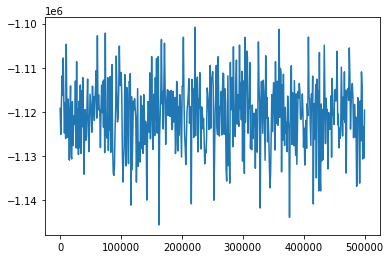

In [52]:
x = np.linspace(1, 500001, 500)
plt.plot(x, all_reward)

In [50]:
test(Q)

## Q-Learning

In [53]:
env = gym.make('Pendulum-v1')

Q_table = np.zeros([state_bins[0], state_bins[1], action_bins])
alpha = 0.1
gamma = 0.99
epsilon = 0.1

all_reward_QL = []
epi_reward = 0

for i in range(1, 100001):
    state = env.reset()
    ds = discretize_state(state)
    
    done = False
    
    while not done:

        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
            action, action_idx = discretize_action(action)
        else:
            action_idx = np.argmax(Q[ds]) 
            action = action_space[action_idx] -1e-6
        
        next_state, reward, done, info = env.step([action])
        nds = discretize_state(next_state)
        
        Q_table[ds][action_idx] = (1 - alpha) * Q_table[ds][action_idx] + alpha * (reward + gamma * np.max(Q_table[nds]))
        
        state = next_state
        ds = nds
        
        epi_reward += reward
        
        if done:
            break
    
    if i % 100 == 0:
        print('Episode:', i)
    
    if i % 1000 == 0:
        clear_output(wait=True)
        all_reward_QL.append(epi_reward)
        print('Episode:', i)
        print('Average reward', epi_reward / 1000)
        epi_reward = 0

print('학습 완료')

Episode: 100000
Average reward -1103.8898868379065
학습 완료


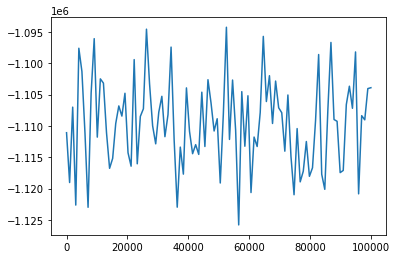

In [54]:
x = np.linspace(1, 100001, 100)
plt.plot(x, all_reward_QL)